In [1]:
# Imports
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
import os
import pandas as pd
import numpy as np
import pickle as pk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
list_nPCs = [10, 15, 20, 25, 30, 35, 40]
takeprofit = 0.12
stoploss = 0.05

In [3]:
# Load previously built datasets : we just need train sets and validation sets here
trainset_final = pd.read_csv('./Data/Trainset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit))
trainset = pd.read_csv('./Data/Trainset_SL{}_TP{}.csv'.format(stoploss, takeprofit))

validation_set_final = pd.read_csv('./Data/Validationset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit))
validation_set = pd.read_csv('./Data/Validationset_SL{}_TP{}.csv'.format(stoploss, takeprofit))

In [4]:
# Hotfix function
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

def make_keras_picklable():
    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))
    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

In [5]:
# Build and train several models different amounts of PCs
for nPCs in list_nPCs:
    print(nPCs)
    X = trainset_final.iloc[:, :nPCs]
    y = trainset["result"]

    # Build model and train it
    classifier = Sequential()
    dropout_fraction = 0.2
    #First Hidden Layer
    classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal', input_dim=nPCs))
    classifier.add(Dropout(dropout_fraction))
    #Second, third and fourth  hidden Layers
    classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dropout(dropout_fraction))
    classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dropout(dropout_fraction))
    classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dropout(dropout_fraction))

    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    #Fitting the data to the training dataset
    classifier.fit(X,y, batch_size=15, epochs=100, verbose =1)

    pk.dump(classifier, open("./Models/DL_model_{}PC_stoploss{}_takeprofit{}.pkl".format(nPCs, stoploss, takeprofit),"wb"))

======] - 2s 2ms/step - loss: 0.6933 - accuracy: 0.4735
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4699
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5484
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5234
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5932
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6690 - accuracy: 0.8110
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6103 - accuracy: 0.8592
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4769 - accuracy: 0.8957
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: 0.3297 - accuracy: 0.9603
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2473 - accuracy: 0.9562
Epoch 11/100
15/15 [==============================] 

In [6]:
X_test = validation_set_final
y_test = validation_set['result']

In [7]:
accuracies, nPCs_list = [], []
for nPCs in list_nPCs:
    print(nPCs)
    with open("./Models/DL_model_{}PC_stoploss{}_takeprofit{}.pkl".format(nPCs, stoploss, takeprofit), 'rb') as f:
        clf = pk.load(f)
    # Compute predictions on testset
    preds = (clf.predict(validation_set_final.iloc[:, :nPCs]) > 0.5)*1

    # Assess accuracy on Bullish predictions only (because we assume only performing Bullish trades) 
    validation_set1 = validation_set[preds == 1].copy()
    accuracies.append(np.mean(preds == list(validation_set['result'])))
    nPCs_list.append(nPCs)

10
15
20
25
30
35
40


In [8]:
recap = pd.DataFrame({'nPCs' : list(nPCs_list), 'Accuracy' : (list(accuracies))})
recap.to_csv('./Results/Comparative_All_models_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)
print(recap)

   nPCs  Accuracy
0    10  0.624444
1    15  0.615556
2    20  0.513333
3    25  0.500000
4    30  0.553333
5    35  0.557778
6    40  0.486667


In [9]:
print(clf.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                1312      
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)               

In [10]:
import tensorflow as tf

X = trainset_final.iloc[:, :10]
y = trainset["result"]
X_val = validation_set_final.iloc[:, :10]
y_val = validation_set['result']
# Build model and train it
classifier = Sequential()
dropout_fraction = 0.2
# First Hidden Layer
classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal', input_dim=10))
classifier.add(Dropout(dropout_fraction))
# Second, third and fourth hidden Layers
classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(dropout_fraction))
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(dropout_fraction))
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(dropout_fraction))

# Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
# Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =[
    "accuracy",
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
    ])
# Fitting the data to the training dataset
model = classifier.fit(X,y, batch_size=15, epochs=100, validation_data=(X_val, y_val), verbose =1)

=========================] - 0s 10ms/step - loss: 0.2403 - accuracy: 0.9174 - tp: 56.4375 - tn: 59.2500 - fp: 8.1250 - fn: 2.2500 - precision: 0.8617 - recall: 0.9750 - auc: 0.9623 - val_loss: 6.2928 - val_accuracy: 0.6167 - val_tp: 1.0000 - val_tn: 36.0000 - val_fp: 2.0000 - val_fn: 21.0000 - val_precision: 0.3333 - val_recall: 0.0455 - val_auc: 0.4970
Epoch 51/100
15/15 [==============================] - 0s 9ms/step - loss: 0.1757 - accuracy: 0.9347 - tp: 54.6875 - tn: 62.6875 - fp: 4.2500 - fn: 4.4375 - precision: 0.9241 - recall: 0.9305 - auc: 0.9754 - val_loss: 6.2426 - val_accuracy: 0.6000 - val_tp: 0.0000e+00 - val_tn: 36.0000 - val_fp: 2.0000 - val_fn: 22.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4970
Epoch 52/100
15/15 [==============================] - 0s 9ms/step - loss: 0.1641 - accuracy: 0.9588 - tp: 59.1875 - tn: 61.1250 - fp: 4.6250 - fn: 1.1250 - precision: 0.9341 - recall: 0.9832 - auc: 0.9808 - val_loss: 6.2667 - val_accuracy: 0.6000 - val

In [11]:
epochs = 100

    Epoch     Train        Val
0       1  0.693153   0.692954
1       2  0.693182   0.693112
2       3  0.692874   0.691977
3       4  0.691953   0.689755
4       5  0.687144   0.679650
5       6  0.667972   0.646816
6       7  0.607840   0.637030
7       8  0.552326   0.800352
8       9  0.497715   0.879990
9      10  0.460343   0.952721
10     11  0.415119   1.097705
11     12  0.371828   1.267400
12     13  0.388434   1.392817
13     14  0.357862   1.734571
14     15  0.318085   1.738253
15     16  0.331908   1.864074
16     17  0.316284   2.052934
17     18  0.309935   2.360882
18     19  0.335855   2.345173
19     20  0.264860   2.670964
20     21  0.270333   2.860036
21     22  0.269904   2.851962
22     23  0.291299   3.067611
23     24  0.246261   3.415552
24     25  0.238809   3.899911
25     26  0.269903   4.097299
26     27  0.243972   4.053729
27     28  0.227850   4.119299
28     29  0.244391   4.200919
29     30  0.242321   4.052351
..    ...       ...        ...
70     7

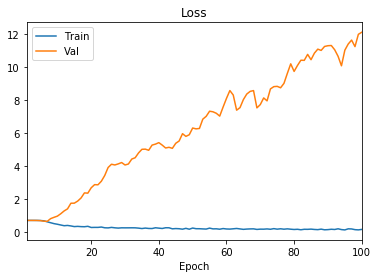

In [12]:
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": model.history["loss"],
        "Val": model.history["val_loss"],
    }
)
print(loss_df)
loss_df.set_index("Epoch", inplace=True)
loss_df.plot(title="Loss")

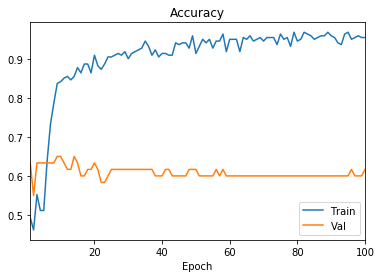

In [13]:
accuracy_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": model.history["accuracy"],
        "Val": model.history["val_accuracy"],
    }
)
accuracy_df.set_index("Epoch", inplace=True)
accuracy_df.plot(title="Accuracy")

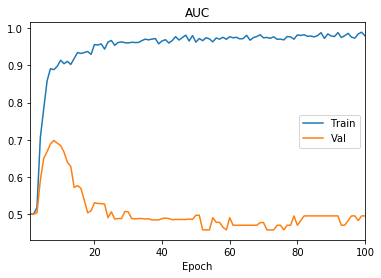

In [14]:
# Plotting AUC
auc_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": model.history["auc"],
        "Val": model.history["val_auc"],
    }
)
auc_df.set_index("Epoch", inplace=True)
auc_df.plot(title="AUC")

In [15]:
results = validation_set.copy()

In [16]:
results['preds'] = preds

In [17]:
results = results[['result','preds']]

In [18]:
results

,result,preds
0,1,0
1,0,0
2,1,0
3,1,0
4,0,0
5,0,0
6,1,0
7,1,0
8,0,0
9,0,0
